In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os

from torch.autograd import Variable
from torchsummary import summary

In [2]:
print(os.listdir("./assets/data"))

['training_fake', 'training_real']


In [3]:
fake = "./assets/data/training_fake/"
real = "./assets/data/training_real/"

fake_path = os.listdir(fake)
real_path = os.listdir(real)
dataset_path = "./assets/data/"

In [4]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

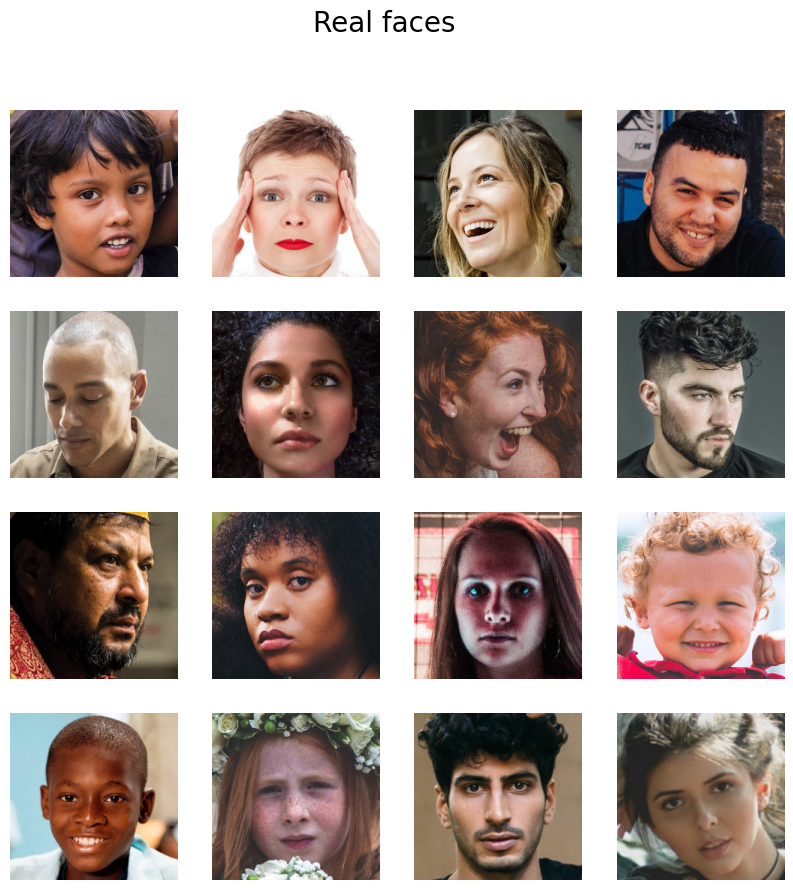

In [5]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces", fontsize=20)
    plt.axis('off')

plt.show()

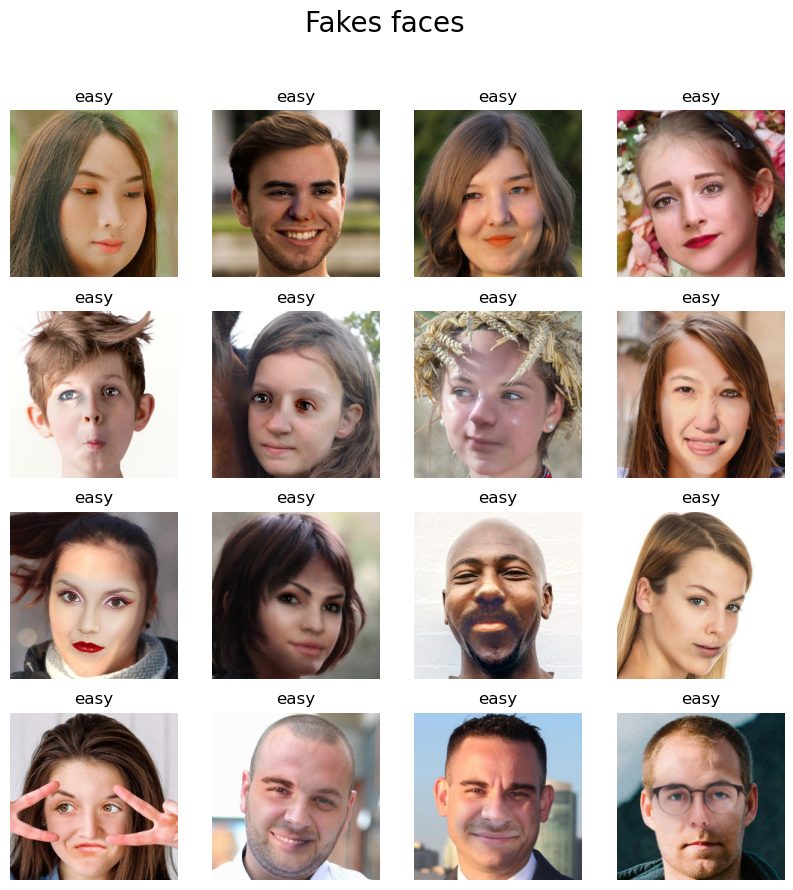

In [6]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()
    

## Data processing

In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.Resize((96, 96)),        # Resize images to 96x96
    transforms.ToTensor(),              # Convert images to PyTorch Tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize images
])

full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

dataset_size = len(full_dataset)
split = int(np.floor(0.2 * dataset_size))
indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(full_dataset, batch_size=32, sampler=train_sampler)
validation_loader = DataLoader(full_dataset, batch_size=32, sampler=validation_sampler)

print(f"Found {len(train_indices)} images belonging to {len(full_dataset.classes)} classes for training.")
print(f"Found {len(val_indices)} images belonging to {len(full_dataset.classes)} classes for validation.")


Found 1633 images belonging to 2 classes for training.
Found 408 images belonging to 2 classes for validation.


## Model training

In [8]:
# def evaluate_model(validation_loader, model):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in validation_loader:
#             images, labels = images.to(device), labels.to(device)  # Move data to GPU
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     accuracy = 100 * correct / total
#     print(f'Accuracy on the validation set: {accuracy:.2f}%')

# evaluate_model(validation_loader, model)

In [9]:
def evaluate_model(validation_loader, model, criterion):
    model.eval()  # Make sure the model is in eval mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(validation_loader)
    val_accuracy = correct / total
    
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    
    return val_loss, val_accuracy

In [10]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 2)  # Assuming 2 classes: real and fake
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
# def train_model(train_loader, model, criterion, optimizer, epochs=20):
#     model.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)  # Move data to GPU
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
#         evaluate_model(validation_loader, model)

def train_model(train_loader, validation_loader, model, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        val_loss, val_accuracy = evaluate_model(validation_loader, model, criterion)

        val_losses.append(val_loss)
        val_acc.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

train_model(train_loader, validation_loader, model, criterion, optimizer)

Validation Loss: 0.6911982481296246, Validation Accuracy: 0.5269607843137255
Epoch 1/20 - Loss: 0.7042, Accuracy: 0.53%, Val Loss: 0.6912, Val Accuracy: 0.53%
Validation Loss: 0.6797939538955688, Validation Accuracy: 0.5955882352941176
Epoch 2/20 - Loss: 0.6884, Accuracy: 0.56%, Val Loss: 0.6798, Val Accuracy: 0.60%
Validation Loss: 0.6701270112624536, Validation Accuracy: 0.5906862745098039
Epoch 3/20 - Loss: 0.6827, Accuracy: 0.54%, Val Loss: 0.6701, Val Accuracy: 0.59%
Validation Loss: 0.6711994959757879, Validation Accuracy: 0.6078431372549019
Epoch 4/20 - Loss: 0.6689, Accuracy: 0.60%, Val Loss: 0.6712, Val Accuracy: 0.61%
Validation Loss: 0.6543138669087336, Validation Accuracy: 0.6004901960784313
Epoch 5/20 - Loss: 0.6641, Accuracy: 0.60%, Val Loss: 0.6543, Val Accuracy: 0.60%
Validation Loss: 0.6779493781236502, Validation Accuracy: 0.5784313725490197
Epoch 6/20 - Loss: 0.6489, Accuracy: 0.63%, Val Loss: 0.6779, Val Accuracy: 0.58%
Validation Loss: 0.6808986847217267, Validatio

In [12]:
# model = SimpleCNN().to(device)

summary(model, (3, 96, 96))  # Example for images of size 96x96 with 3 channels (RGB)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
              ReLU-2           [-1, 32, 96, 96]               0
         MaxPool2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
              ReLU-5           [-1, 64, 48, 48]               0
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
              ReLU-8          [-1, 128, 24, 24]               0
         MaxPool2d-9          [-1, 128, 12, 12]               0
           Linear-10                  [-1, 512]       9,437,696
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 2]           1,026
Total params: 9,531,970
Trainable params: 9,531,970
Non-trainable params: 0
---------------------------

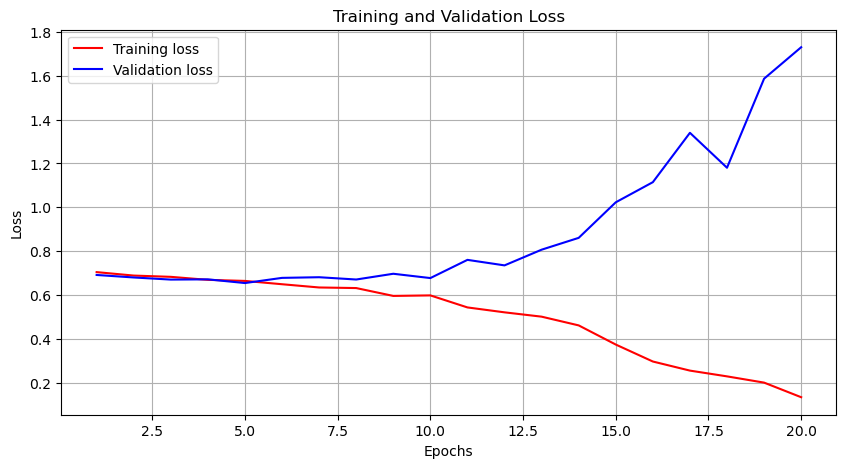

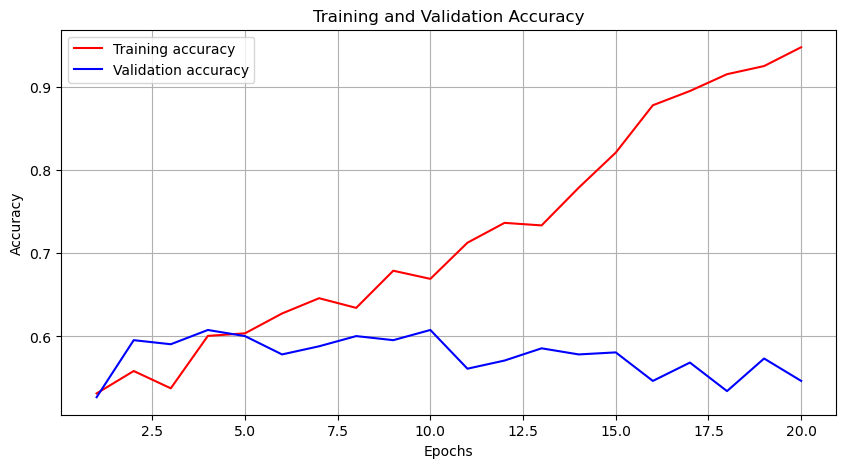

In [13]:
train_losses = train_losses[:20]
val_losses = val_losses[:20]
train_acc = train_acc[:20]
val_acc = val_acc[:20]


epochs = range(1, len(train_losses) + 1)

# Plot for loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()